In [1]:
import json
from tqdm import tqdm

def load_Yelp_data(path):
    final_user_set = {}
    final_item_set = {}
    edge_index = {}
    edge_feature = {}

    with open(path+'yelp_academic_dataset_user.json', 'r', encoding='utf-8') as f:
        all_data = f.readlines()
        for line in tqdm(all_data):
            current_data = json.loads(line)
            current_node = current_data['user_id']
            del current_data['user_id']
            final_user_set[current_node] = current_data      
   
                
    with open(path+'yelp_academic_dataset_business.json', 'r', encoding='utf-8') as f:
        all_data = f.readlines()
        for line in tqdm(all_data):
            current_data = json.loads(line)
            current_node = current_data['business_id']
            del current_data['business_id']
            final_item_set[current_node] = current_data      
            
    
    with open(path+'yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
        all_data = f.readlines()
        for line in tqdm(all_data):
            current_data = json.loads(line)
            current_business = current_data['business_id']
            current_user = current_data['user_id']
            cool_level = int(current_data['funny']) + int(current_data['useful']) + int(current_data['cool'])
            current_edge_feature = {'date':current_data['date'], 'text':current_data['text'], 'rate':current_data['stars'], 'rate_level':cool_level}
            edge_feature[str(current_user) + '|' + str(current_business)] = current_edge_feature
            if current_user in edge_index:
                edge_index[current_user].append(current_business)
            else:
                edge_index[current_user] = [current_business]
                
    return edge_index, final_user_set, final_item_set, edge_feature

In [ ]:
edge_index, final_user_feature_dic, final_item_feature_dic, edge_feature = load_Yelp_data('yelp_dataset/')

 96%|█████████████████████████████████████████████████████████████████▎  | 8287148/8635403 [04:01<00:02, 120644.31it/s]

In [ ]:
import ast
def attribute_analysis(attr):
    final_str = ''
    for key in attr.keys():
        if attr[key][0] != '{' and attr[key][-1] != '}':
            final_str += '{} is {}. '.format(key, attr[key])
        else:
            values = json.loads(json.dumps(ast.literal_eval(attr[key])))
            final_str += 'The business contains {} where '.format(key)
            for sub_key in values:
                final_str+='{} is {}. '.format(sub_key, values[sub_key])
    return final_str

def feature_transformation(final_feature):
    final_feature_dic = {}
    for key_name in tqdm(list(final_feature.keys())):
        feature = final_feature[key_name]
        if 'fans' in feature.keys(): # User feature
            if len(feature['elite'])!=0:
                elite_period = max([int(i) for i in feature['elite'].split(',')]) - min([int(i) for i in feature['elite'].split(',')])
            else:
                elite_period = 0
            friends_count = len(feature['friends'].split(', '))
            valid_user_feature = [feature[i] for i in list(feature.keys())[-13:]]
            temp_feature = [feature['review_count'], feature['useful'], feature['funny'], feature['cool'],elite_period, friends_count]
            final_feature_val = temp_feature + valid_user_feature
            final_feature_dic[key_name] = final_feature_val
        else:
            name = feature['name']
            address = feature['address']
            city = feature['city']
            state = feature['state']
            postal_code = feature['postal_code']
            stars = feature['stars']
            review_count = feature['review_count']
            attribures = feature['attributes']
            categories = 'The business offers {}. '.format(feature['categories'])
            current_address_information = 'The business {} located at {},{},{},{}. '.format(name, address,city,state, postal_code)
            if attribures is not None:
                attributes_information = attribute_analysis(attribures)
            else:
                attributes_information = ''
            final_information = categories + current_address_information + attributes_information
            final_feature_dic[key_name] = final_information
    return final_feature_dic

In [ ]:
final_user_feature = feature_transformation(final_user_feature_dic)

In [ ]:
final_item_feature = feature_transformation(final_item_feature_dic)

In [74]:
def ten_core_user_filter(edge_idex,final_user_feature,final_item_feature, edge_feature,core_threshould, user_limit):
    new_edge_index = [[], []]
    new_edge_feature = {}
    new_user_feature = {}
    new_item_feature = {}
    user_count = 0
    for key in tqdm(edge_idex.keys()):
        current_neighbor = edge_idex[key]
        if len(current_neighbor) >=core_threshould and len(current_neighbor) <=100 and user_count<=user_limit:
            new_edge_index[0].extend([key for i in range(len(current_neighbor))])
            new_user_feature[key] = final_user_feature[key]
            user_count+=1
            for neighbor in current_neighbor:
                new_edge_index[1].append(neighbor)
                new_edge_feature[str(key) + '|' + str(neighbor)] = edge_feature[str(key) + '|' + str(neighbor)]
                new_item_feature[neighbor] = final_item_feature[neighbor]
        else:
            continue
    return new_edge_feature,new_user_feature, new_item_feature, new_edge_index

In [75]:
new_edge_feature,new_user_feature, new_item_feature, new_edge_index = ten_core_user_filter(edge_index,final_user_feature,final_item_feature, edge_feature,core_threshould=10, user_limit=10000)

100%|█████████████████████████████████████████████████████████████████████| 2189457/2189457 [00:28<00:00, 77305.60it/s]


In [76]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

class Generate_dataset(Dataset):
    def __init__(self, data,tokenizer,device, type):
        self.data = data
        self.device = device
        self.tokenizer = tokenizer
        self.type = type
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.type == 'list':
            content = self.data[idx]
        elif self.type == 'dataframe':
            content = self.data.iloc[idx][0]
        content_encoded_input = self.tokenizer(content, padding='max_length', truncation=True,
                                               max_length=256)
        input_ids = torch.tensor(content_encoded_input['input_ids']).to(self.device)
        attention_mask = torch.tensor(content_encoded_input['attention_mask']).to(self.device)
        sample = {'input_ids': input_ids, 'attention_mask': attention_mask}
        return sample


class Sentence_encoding():
    
    def __init__(self, model, tokenizer,device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device 
    #Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(self,model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, final_content, batch_size, type):
        dataset = Generate_dataset(final_content, self.tokenizer, self.device, type)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        if type == 'list':
            outputs = []
            self.model.eval()
            with torch.no_grad():
                for data in tqdm(dataloader):
                    model_output = self.model(input_ids=data['input_ids'], attention_mask=data['attention_mask'])
                    sentence_embeddings = self.mean_pooling(model_output, data['attention_mask'])
                    outputs.append(sentence_embeddings)
            return torch.cat(outputs, dim=0)
        elif type == 'dataframe':
            outputs = {}
            temp_index = 0
            for data in tqdm(dataloader):
                with torch.no_grad():
                    model_output = self.model(input_ids=data['input_ids'], attention_mask=data['attention_mask'])
                    sentence_embeddings = self.mean_pooling(model_output, data['attention_mask'])
                    for index, i in enumerate(sentence_embeddings):
                        final_index = temp_index + index
                        outputs[final_content['News_ID'][final_index]] = sentence_embeddings[index].tolist()
                    temp_index+=batch_size
            return outputs

In [95]:
from transformers import AutoTokenizer, AutoModel
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

In [96]:
model_name = "sentence-transformers/distilbert-base-nli-mean-tokens"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device) 

In [97]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [78]:
import os
def load_embedding(embedding_path,all_item_feature, new_node_feature=None):
    if os.path.isfile(embedding_path):
        new_node_feature = []
        print('File exist, load embedding from {}'.format(embedding_path))
        with open(embedding_path, 'r',encoding='utf-8') as f:
            all_data = f.readlines()
            for line in tqdm(all_data):
                new_node_feature.append([float(i) for i in line.split()])
    else:
        model_name = "sentence-transformers/distilbert-base-nli-mean-tokens"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device) 
        encoder = Sentence_encoding(model, tokenizer,device)
        final_items_embedding = encoder.encode(all_item_feature,128,'list')
        final_items_embedding = [i.tolist() for i in final_items_embedding]
        new_node_feature = final_items_embedding
        with open(embedding_path , 'w', encoding='utf-8') as f:
            for i in tqdm(new_node_feature):
                f.write(' '.join([str(value) for value in i]))
                f.write('\n')
    return new_node_feature

In [79]:
item_embedding_path = 'Data/item_embedding.txt'
all_item_feature = list(new_item_feature.values())

In [80]:
def feature_padding(feature):
    for index, i in enumerate(feature):
        if len(i)<768:
            feature[index] = i + [-1 for n in range(768-len(i))]
    return feature

In [81]:
all_item_feature = load_embedding(item_embedding_path,all_item_feature)

File exist, load embedding from Data/item_embedding.txt


100%|██████████████████████████████████████████████████████████████████████████| 76722/76722 [00:28<00:00, 2707.09it/s]


In [82]:
all_user_feature = list(new_user_feature.values())
all_user_feature = feature_padding(all_user_feature)
for index, key in enumerate(new_user_feature.keys()):
    new_user_feature[key] = all_user_feature[index]

In [83]:
for index, key in enumerate(new_item_feature.keys()):
    new_item_feature[key] = all_item_feature[index]

In [84]:
import numpy as np
import scipy.sparse as sp
def map_data(data):
    uniq = list(set(data))
    id_dict = {old: new for new, old in enumerate(sorted(uniq))}
    data = np.array([id_dict[x] for x in data])
    n = len(uniq)
    return data, id_dict, n

def feature_transform(edge_index, final_user_feature, final_item_feature, edge_feature):
        u_nodes_ratings = edge_index[0]
        v_nodes_ratings = edge_index[1]
        ratings = []
        timestamp = []
        for index in range(len(u_nodes_ratings)):
            ratings.append(edge_feature[u_nodes_ratings[index]+ '|' +v_nodes_ratings[index]]['rate'])
            timestamp.append(edge_feature[u_nodes_ratings[index]+ '|' +v_nodes_ratings[index]]['date'])
        
        u_nodes_ratings, u_dict, num_users = map_data(u_nodes_ratings)
        v_nodes_ratings, v_dict, num_items = map_data(v_nodes_ratings)
        u_nodes_ratings, v_nodes_ratings = u_nodes_ratings.astype(np.int64), v_nodes_ratings.astype(np.int32)
        ratings = np.array(ratings).astype(np.float64)

        u_features = np.zeros((num_users, 768), dtype=np.float32)
        v_features = np.zeros((num_items, 768), dtype=np.float32)
        for key in u_dict.keys():
            u_features[u_dict[key]] = final_user_feature[key]
            
        for key in v_dict.keys():
            v_features[v_dict[key]] = final_item_feature[key]        
        
        u_features = sp.csr_matrix(u_features)
        v_features = sp.csr_matrix(v_features)

        return num_users, num_items, u_nodes_ratings, v_nodes_ratings, ratings,timestamp,u_features, v_features, u_dict,v_dict

In [85]:
num_users, num_items, u_nodes_ratings, v_nodes_ratings, ratings, timestamp,u_features, v_features,u_dict,v_dict = feature_transform(new_edge_index, new_user_feature, new_item_feature, new_edge_feature)

In [87]:
json.dump(new_item_feature, open( "Data/new_item_feature.json", 'w' ))

In [51]:
import time
from datetime import datetime
all_time = []
for i in timestamp:
    datetime_object = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    all_time.append(time.mktime(datetime_object.timetuple()))
# sorted_unique = sorted(set(all_time))
# ordinal_map = {val: i for i, val in enumerate(sorted_unique, 1)}
# all_time_sequence = [ordinal_map[i] for i in all_time]

In [214]:
max_val = max(all_time)
final_time = [i/max_val-0.1 for i in all_time]

In [215]:
import json
json.dump(u_dict, open( "Data/u_dict.json", 'w' ))
json.dump(v_dict, open( "Data/v_dict.json", 'w' ))

In [216]:
datasplit_path = 'Data/final_data_new'

In [217]:
import pickle as pkl
with open(datasplit_path, 'wb') as f:
    pkl.dump([num_users, num_items, u_nodes_ratings, v_nodes_ratings, ratings,final_time, u_features, v_features], f)

## Start from here

In [1]:
datasplit_path = 'Data/final_data_new'

In [2]:
import random
def create_trainvaltest_split(datasplit_path,ratio=1.0, hop=1, sample_ratio=1.0, max_nodes_per_hop=100):
    if os.path.isfile(datasplit_path):
        print('Reading processed dataset from file...')
        with open(datasplit_path, 'rb') as f:
            num_users, num_items, u_nodes, v_nodes, ratings,timestamp, u_features, v_features = pkl.load(f)

        print('Number of users = %d' % num_users)
        print('Number of items = %d' % num_items)
        print('Number of links = %d' % ratings.shape[0])
        print('Fraction of positive links = %.4f' % (float(ratings.shape[0]) / (num_users * num_items),))


    rating_dict = {r: i for i, r in enumerate(np.sort(np.unique(ratings)).tolist())}
    print("Using random dataset split ...")
    num_test = int(np.ceil(ratings.shape[0] * 0.1))
    num_val = int(np.ceil(ratings.shape[0] * 0.9 * 0.05))
    num_train = ratings.shape[0] - num_val - num_test

    pairs_nonzero = np.vstack([u_nodes, v_nodes]).transpose()

    train_pairs_idx = pairs_nonzero[0:int(num_train*ratio)]
    val_pairs_idx = pairs_nonzero[num_train:num_train + num_val]
    test_pairs_idx = pairs_nonzero[num_train + num_val:]

    u_test_idx, v_test_idx = test_pairs_idx.transpose()
    u_val_idx, v_val_idx = val_pairs_idx.transpose()
    u_train_idx, v_train_idx = train_pairs_idx.transpose()

    # create labels
    all_labels = np.array([rating_dict[r] for r in ratings], dtype=np.int32)
    
    train_labels = all_labels[0:int(num_train*ratio)]
    val_labels = all_labels[num_train:num_train + num_val]
    test_labels = all_labels[num_train + num_val:]
    
    train_time = timestamp[0:int(num_train*ratio)]
    val_time =timestamp[num_train:num_train + num_val]
    test_time = timestamp[num_train + num_val:]
    
    
    class_values = np.sort(np.unique(ratings))

    # make training adjacency matrix

    data_train = train_labels + 1.
    data_train = np.array([i + train_time[index] for index, i in enumerate(data_train)])
    data_train = data_train.astype(np.float32)
    data_test = test_labels + 1.
    
    data_test = np.array([i + test_time[index] for index, i in enumerate(data_test)])
    data_test = data_test.astype(np.float32)
    
    data_val = val_labels + 1.
    data_val = np.array([i + val_time[index] for index, i in enumerate(data_val)])
    data_val = data_val.astype(np.float32)
    

    
    rating_mx_train = sp.csr_matrix((data_train, [u_train_idx, v_train_idx]), 
                                    shape=[num_users, num_items], dtype=np.float32)
    
    rating_mx_test = sp.csr_matrix((data_test, [u_test_idx, v_test_idx]), 
                                    shape=[num_users, num_items], dtype=np.float32)
    
    rating_mx_val = sp.csr_matrix((data_val, [u_val_idx, v_val_idx]), 
                                    shape=[num_users, num_items], dtype=np.float32)
    
    
    
    u_features, v_features = u_features.toarray(), v_features.toarray()
    n_features = u_features.shape[1] + v_features.shape[1]
    print('Number of user features {}, item features {}, total features {}'.format(
        u_features.shape[1], v_features.shape[1], n_features))
    
    u_features, v_features, adj_train, train_labels, train_u_indices, train_v_indices, val_labels, val_u_indices, val_v_indices, test_labels, test_u_indices, test_v_indices, class_values = u_features, v_features, rating_mx_train, train_labels, u_train_idx, v_train_idx, val_labels, u_val_idx, v_val_idx, test_labels, u_test_idx, v_test_idx, class_values
    
    train_indices = (train_u_indices, train_v_indices)
    val_indices = (val_u_indices, val_v_indices)
    test_indices = (test_u_indices, test_v_indices)
    print('#train: %d, #val: %d, #test: %d' % (
        len(train_u_indices), 
        len(val_u_indices), 
        len(test_u_indices), 
    ))
    
    
    train_graphs = MyDynamicDataset(
        'Data',
        adj_train, 
        train_indices, 
        train_labels, 
        hop, 
        sample_ratio, 
        max_nodes_per_hop, 
        u_features, 
        v_features, 
        class_values, 
    )
    

    test_graphs = MyDynamicDataset(
        'Data',
        rating_mx_test, 
        test_indices, 
        test_labels, 
        hop, 
        sample_ratio, 
        max_nodes_per_hop, 
        u_features, 
        v_features, 
        class_values, 
    )


    val_graphs = MyDynamicDataset(
        'Data',
        rating_mx_val, 
        val_indices, 
        val_labels, 
        hop, 
        sample_ratio, 
        max_nodes_per_hop, 
        u_features, 
        v_features, 
        class_values, 
    )
    return train_graphs, val_graphs, test_graphs,class_values

In [85]:
def subgraph_extraction_labeling(ind, Arow, Acol, h=1, sample_ratio=1.0, max_nodes_per_hop=None, 
                                 u_features=None, v_features=None, class_values=None, 
                                 y=1):
    # extract the h-hop enclosing subgraph around link 'ind'
    i,j = ind[0], ind[1]
    u_nodes, v_nodes = [ind[0]], [ind[1]]
    u_dist, v_dist = [0], [0]
    u_visited, v_visited = set([ind[0]]), set([ind[1]])
    u_fringe, v_fringe = set([ind[0]]), set([ind[1]])
    
    for dist in range(1, h+1):
        v_fringe = neighbors(u_fringe, Arow)
        u_fringe = neighbors(v_fringe, Acol)
        
        u_fringe = u_fringe - u_visited
        v_fringe = v_fringe - v_visited
        u_visited = u_visited.union(u_fringe)
        v_visited = v_visited.union(v_fringe)
        if sample_ratio < 1.0:
            u_fringe = random.sample(u_fringe, int(sample_ratio*len(u_fringe)))
            v_fringe = random.sample(v_fringe, int(sample_ratio*len(v_fringe)))
        if max_nodes_per_hop is not None:
            if max_nodes_per_hop < len(u_fringe):
                u_fringe = random.sample(u_fringe, max_nodes_per_hop)
            if max_nodes_per_hop < len(v_fringe):
                v_fringe = random.sample(v_fringe, max_nodes_per_hop)
        if len(u_fringe) == 0 and len(v_fringe) == 0:
            break
        u_nodes = u_nodes + list(u_fringe)
        v_nodes = v_nodes + list(v_fringe)
        u_dist = u_dist + [dist] * len(u_fringe)
        v_dist = v_dist + [dist] * len(v_fringe)
    subgraph = Arow[u_nodes][:, v_nodes]
    # remove link between target nodes
    subgraph[0, 0] = 0
    # prepare pyg graph constructor input
    
    u, v, r = ssp.find(subgraph)  # r is 1, 2... (rating labels + 1)
    v += len(u_nodes)
    r = r - 1  # transform r back to rating label

    num_nodes = len(u_nodes) + len(v_nodes)
    node_labels = [x*2 for x in u_dist] + [x*2+1 for x in v_dist]
    max_node_label = 2*h + 1
    y = class_values[y]
    
    # get node features
    if u_features is not None:
        u_features = u_features[u_nodes]
    if v_features is not None:
        v_features = v_features[v_nodes]
    
    node_features = [u_features, v_features] 
      
    return i,j,u, v, r, node_labels, max_node_label, y, node_features

In [86]:
from torch_geometric.data import Data,Dataset
import pickle as pkl
import os
import scipy.sparse as sp
import numpy as np
import scipy.io as sio
import scipy.sparse as ssp
import torch

def neighbors(fringe, A):
    # find all 1-hop neighbors of nodes in fringe from A
    if not fringe:
        return set([])
    return set(A[list(fringe)].indices)


def one_hot(idx, length):
    idx = np.array(idx)
    x = np.zeros([len(idx), length])
    x[np.arange(len(idx)), idx] = 1.0
    return x


class SparseRowIndexer:
    def __init__(self, csr_matrix):
        data = []
        indices = []
        indptr = []

        for row_start, row_end in zip(csr_matrix.indptr[:-1], csr_matrix.indptr[1:]):
            data.append(csr_matrix.data[row_start:row_end])
            indices.append(csr_matrix.indices[row_start:row_end])
            indptr.append(row_end - row_start)  # nnz of the row

        self.data = np.array(data, dtype=object)
        self.indices = np.array(indices, dtype=object)
        self.indptr = np.array(indptr, dtype=object)
        self.shape = csr_matrix.shape

    def __getitem__(self, row_selector):
        indices = np.concatenate(self.indices[row_selector])
        data = np.concatenate(self.data[row_selector])
        indptr = np.append(0, np.cumsum(self.indptr[row_selector]))
        shape = [indptr.shape[0] - 1, self.shape[1]]
        return ssp.csr_matrix((data, indices, indptr), shape=shape)


class SparseColIndexer:
    def __init__(self, csc_matrix):
        data = []
        indices = []
        indptr = []

        for col_start, col_end in zip(csc_matrix.indptr[:-1], csc_matrix.indptr[1:]):
            data.append(csc_matrix.data[col_start:col_end])
            indices.append(csc_matrix.indices[col_start:col_end])
            indptr.append(col_end - col_start)

        self.data = np.array(data, dtype=object)
        self.indices = np.array(indices, dtype=object)
        self.indptr = np.array(indptr, dtype=object)
        self.shape = csc_matrix.shape

    def __getitem__(self, col_selector):
        indices = np.concatenate(self.indices[col_selector])
        data = np.concatenate(self.data[col_selector])
        indptr = np.append(0, np.cumsum(self.indptr[col_selector]))

        shape = [self.shape[0], indptr.shape[0] - 1]
        return ssp.csc_matrix((data, indices, indptr), shape=shape)

class MyDynamicDataset(Dataset):
    def __init__(self, root, A, links, labels, h, sample_ratio, max_nodes_per_hop, 
                 u_features, v_features, class_values, max_num=None):
        super(MyDynamicDataset, self).__init__(root)
        self.Arow = SparseRowIndexer(A)
        self.Acol = SparseColIndexer(A.tocsc())
        self.links = links                           
        self.labels = labels
        self.h = h
        self.sample_ratio = sample_ratio
        self.max_nodes_per_hop = max_nodes_per_hop
        self.u_features = u_features
        self.v_features = v_features
        self.class_values = class_values
        if max_num is not None:
            np.random.seed(123)
            num_links = len(links[0])
            perm = np.random.permutation(num_links)
            perm = perm[:max_num]
            self.links = (links[0][perm], links[1][perm])
            self.labels = labels[perm]
    def len(self):
        return len(self.links[0])

    def get(self, idx):
        i, j = self.links[0][idx], self.links[1][idx]
        g_label = self.labels[idx]
        tmp = subgraph_extraction_labeling(
            (i, j), self.Arow, self.Acol, self.h, self.sample_ratio, self.max_nodes_per_hop, 
            self.u_features, self.v_features, self.class_values, g_label
        )
        return construct_pyg_graph(*tmp)
    
    
def construct_pyg_graph(i,j, u, v, r, node_labels, max_node_label, y, node_features):
    u, v = torch.LongTensor(u), torch.LongTensor(v)
    u_idx, v_idx = torch.LongTensor([i]), torch.LongTensor([j])
    r = torch.FloatTensor(r)  
    edge_index = torch.stack([torch.cat([u, v]), torch.cat([v, u])], 0)
    edge_type = torch.cat([r, r]).tolist()
    rate_val = torch.FloatTensor([int(i) for i in edge_type])
    torch.set_printoptions(precision=21)
    time_val = torch.FloatTensor([i%1 for i in edge_type])
    x = torch.FloatTensor(one_hot(node_labels, max_node_label+1))
    y = torch.FloatTensor([y])
    u_feature, v_feature = node_features
    u_feature_tensor = torch.FloatTensor(u_feature)
    v_feature_tensor = torch.FloatTensor(v_feature)
    data = Data(x, edge_index, edge_type=rate_val, y=y, user_index = u_idx, item_index = v_idx, time_val = time_val, 
                user_len = u_feature_tensor.shape[0], item_len = v_feature_tensor.shape[0])
    data.side_feature = torch.cat([u_feature_tensor, v_feature_tensor], dim=0)

    return data

In [87]:
train_graphs, val_graphs, test_graphs,class_values = create_trainvaltest_split(datasplit_path)

Reading processed dataset from file...
Number of users = 10001
Number of items = 76722
Number of links = 316643
Fraction of positive links = 0.0004
Using random dataset split ...
Number of user features 768, item features 768, total features 1536
#train: 270729, #val: 14249, #test: 31665


In [71]:
import networkx as nx
import torch_geometric
sample = train_graphs[4]
G = torch_geometric.utils.to_networkx(sample, to_undirected=True)

C:\Users\yli62\AppData\Local\Temp/ipykernel_2644/1334874663.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_fringe = random.sample(u_fringe, max_nodes_per_hop)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


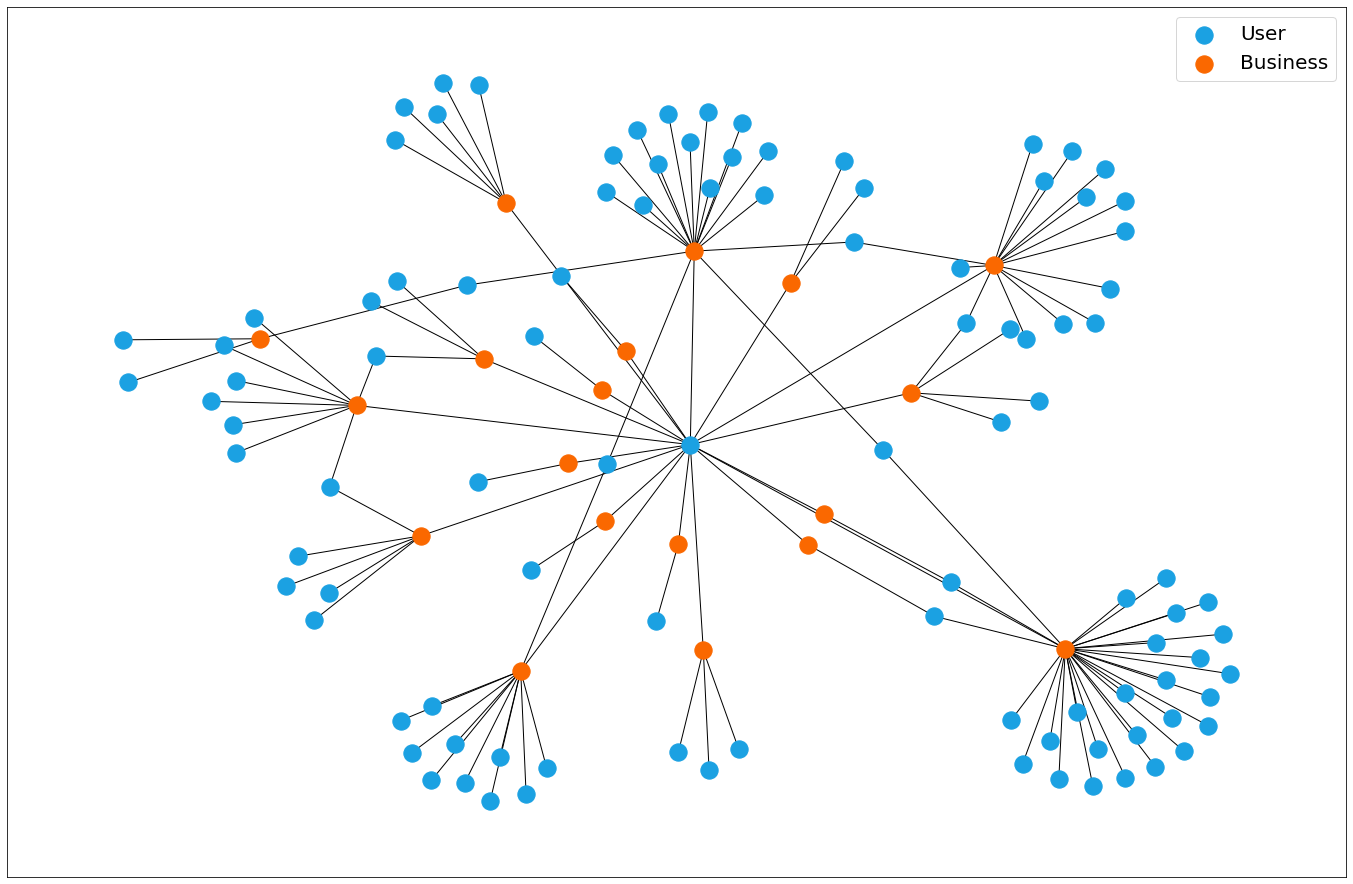

In [94]:
import matplotlib.pyplot as plt

def color_rgb(tmp):
    tmp = list(tmp)
    for key, i in enumerate(tmp):
        tmp[key] = i/255
    return tuple(tmp)

plt.figure(3,figsize=(24,16)) 

user_node = [i for i in range(sample.user_len)]
item_node = [i for i in range(sample.user_len, sample.user_len + sample.item_len)]


pos = nx.spring_layout(G) 

nx.draw_networkx_nodes(G, pos=pos, nodelist=user_node,
                       node_color=color_rgb((27,161,226)), label='User')
nx.draw_networkx_nodes(G, pos=pos, nodelist=item_node,
                       node_color=color_rgb((250,104,0)), label='Business')


nx.draw_networkx_edges(G, pos=pos)
plt.legend(scatterpoints = 1,fontsize=20)
plt.show()

In [6]:
print('Used #train graphs: %d, #test graphs: %d' % (
    len(train_graphs), 
    len(test_graphs), 
))

Used #train graphs: 270729, #test graphs: 31665


In [7]:
import torch
import math
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn import Linear, Conv1d
from torch_geometric.nn import GCNConv, RGCNConv, global_sort_pool, global_add_pool
from torch_geometric.utils import dropout_adj

In [8]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(attn_logits == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [9]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.3):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [11]:
class LSTM_variable_input(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.lstm1 = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = torch.nn.Dropout(0.2)
        self.Linear = torch.nn.Linear(hidden_dim, hidden_dim)
    def forward(self, x, s):
        x = self.dropout(x)
        x_pack = torch.nn.utils.rnn.pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        _, (ht, _) = self.lstm1(x_pack)
        output = self.dropout(ht[-1])
        output = torch.nn.LeakyReLU()(self.Linear(output))
        return output

In [1]:
4 * 32 + 32 * 32 * 3

3200

In [12]:
class IGMC(torch.nn.Module):
    # The GNN model of Inductive Graph-based Matrix Completion. 
    # Use RGCN convolution + center-nodes readout.
    def __init__(self, dataset, device, gconv=RGCNConv, latent_dim=[32, 32, 32, 32], 
                 num_relations=5, num_bases=2, regression=False, adj_dropout=0.2, 
                 force_undirected=False, n_side_features=0, 
                 multiply_by=1, model_type = 'lstm', num_layers = None, num_heads = 8):
        super(IGMC, self).__init__()
        self.regression = regression
        self.adj_dropout = adj_dropout 
        self.force_undirected = force_undirected
        self.model_type = model_type
        self.n_side_features = n_side_features
        self.device = device
        if model_type == 'lstm':
            self.time_module = LSTM_variable_input(embedding_dim=n_side_features, hidden_dim=n_side_features)
            
        elif model_type == 'attention' and num_layers is not None:
            input_dim = n_side_features
            self.num_layers = num_layers
            dim_feedforward = n_side_features

            self.time_module = torch.nn.ModuleList([EncoderBlock(input_dim=input_dim, dim_feedforward=dim_feedforward, num_heads = num_heads) for _ in range(num_layers)])
            
        
        self.multiply_by = multiply_by
        self.convs = torch.nn.ModuleList()
        self.convs.append(gconv(4, latent_dim[0], num_relations, num_bases))
        for i in range(0, len(latent_dim)-1):
            self.convs.append(gconv(latent_dim[i], latent_dim[i+1], num_relations, num_bases)) 
        
        self.lin1 = Linear(2*sum(latent_dim)+n_side_features*2+19, n_side_features)
        self.lin1_2 = Linear(n_side_features, 128)
        
        if self.regression:
            self.lin2 = Linear(128, 1)
        else:
            self.lin2 = Linear(128, 5)
            
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        
    def forward(self, data):
        x, edge_index, edge_type, batch, timestamp= data.x, data.edge_index, data.edge_type, data.batch, data.time_val
        if self.adj_dropout > 0:
            edge_index, edge_type = dropout_adj(
                edge_index, edge_type, p=self.adj_dropout, 
                force_undirected=self.force_undirected, num_nodes=len(x), 
                training=self.training
            )
        
        concat_states = []
        for conv in self.convs:
            x = torch.tanh(conv(x, edge_index, edge_type))
            concat_states.append(x)
    
        concat_states = torch.cat(concat_states, 1)
        users = data.x[:, 0] == 1
        items = data.x[:, 1] == 1
        
        user_index = users.nonzero(as_tuple=True)[0]

        final_feature = data.side_feature
        Item_list_all = []
        len_all = []
        for user in user_index:
            current_item_idx= (edge_index[0] == user).nonzero(as_tuple=True)[0]
            current_item = torch.index_select(edge_index[1],0, current_item_idx)
            if current_item_idx.shape[0] == 0:
                print('exception occur')
                current_item_idx = (edge_index[1] == user).nonzero(as_tuple=True)[0]
                current_item = torch.index_select(edge_index[0],0, current_item_idx)
            current_time = torch.index_select(timestamp, 0, current_item_idx)
            _, time_indices = torch.sort(current_time)
            temp_dic = dict(zip(time_indices.tolist(),current_item.tolist()))
            sort_dic = dict(sorted(temp_dic.items()))
            current_items = torch.index_select(final_feature, 0, torch.tensor(list(sort_dic.values())).to(self.device))
            Item_list_all.append(current_items)
            len_all.append(current_item.shape[0])
        

    
        final_time_feature = torch.nn.utils.rnn.pad_sequence(Item_list_all, batch_first=True)
        
        if self.model_type == 'attention':
            max_len = max(len_all)
            pos_encode =  PositionalEncoding(self.n_side_features, max_len=max_len).to(self.device)
            final_time_feature = pos_encode(final_time_feature)

        
        
        if self.model_type == 'attention':
            for l in self.time_module:
                len_all = torch.tensor(len_all)
                mask = torch.arange(final_time_feature.size(1))[None, :] < len_all[:, None]
                mask = mask.to(device)
                final_time_feature = l(final_time_feature, mask=mask)
            # Mean pooling for the transformers's output
            input_mask_expanded = mask.unsqueeze(-1).expand(final_time_feature.size()).float()
            sum_embeddings = torch.sum(final_time_feature * input_mask_expanded, 1)
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            time_feature = sum_embeddings / sum_mask
        else:
            time_feature = self.time_module(final_time_feature,len_all)
            
        user_feature = torch.cat([concat_states[users], final_feature[users][:,:19], time_feature], 1)
        item_feature = torch.cat([concat_states[items], final_feature[items]], 1)
        
        x = torch.cat([user_feature, item_feature], 1)
#         x = torch.cat([concat_states[users], concat_states[items]], 1)        
#         x = torch.cat([x, final_feature[users][:,:19], final_feature[items], time_feature], 1)
        
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin1_2(x))
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.lin2(x)
        if self.regression:
            return x[:, 0] * self.multiply_by, user_feature, item_feature
        else:
            return F.log_softmax(x, dim=-1), user_feature, item_feature

In [13]:
def logger(info, model, optimizer):
    epoch, train_loss, test_rmse = info['epoch'], info['train_loss'], info['test_rmse']
    with open(os.path.join(res_dir, 'log.txt'), 'a') as f:
        f.write('Epoch {}, train loss {}, test rmse {}\n'.format(
            epoch, train_loss, test_rmse))
    if type(epoch) == int and epoch % 10 == 0:
        print('Saving model states...')
        model_name = os.path.join(res_dir, 'model_checkpoint{}.pth'.format(epoch))
        optimizer_name = os.path.join(
            res_dir, 'optimizer_checkpoint{}.pth'.format(epoch)
        )
        if model is not None:
            torch.save(model.state_dict(), model_name)
        if optimizer is not None:
            torch.save(optimizer.state_dict(), optimizer_name)

In [14]:
import multiprocessing as mp
import time
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from tqdm import tqdm
import torch.nn.functional as F
def eval_rmse(model, loader, device, regression = False, show_progress=False):
    mse_loss = eval_loss(model, loader, device, regression, show_progress)
    rmse = math.sqrt(mse_loss)
    return rmse

def num_graphs(data):
    if data.batch is not None:
        return data.num_graphs
    else:
        return data.x.size(0)

def train(model, optimizer, loader, device, regression=True, ARR=0, 
          show_progress=True, epoch=None):
    model.train()
    total_loss = 0
    pbar = tqdm(loader)
    for data in pbar:
        optimizer.zero_grad()
        data = data.to(device)
        out,_,_ = model(data)
        if regression:
            loss = F.mse_loss(out, data.y.view(-1))
        else:
            label = torch.add(data.y.view(-1).long(), -1)
            loss = F.nll_loss(out, label)
        if show_progress:
            pbar.set_description('Epoch {}, batch loss: {}'.format(epoch, loss.item()))
        if ARR != 0:
            
            for gconv in model.convs:
                w = torch.matmul(
                    gconv.comp,
                    gconv.weight.view(gconv.num_bases, -1)
                ).view(gconv.num_relations, gconv.in_channels, gconv.out_channels)
                reg_loss = torch.sum((w[1:, :, :] - w[:-1, :, :])**2)
                loss += ARR * reg_loss
        loss.backward()
        total_loss += loss.item() * num_graphs(data)
        optimizer.step()
        torch.cuda.empty_cache()
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, device, regression=False, show_progress=False):
    model.eval()
    loss = 0
    if show_progress:
        print('Testing begins...')
        pbar = tqdm(loader)
    else:
        pbar = loader
    for data in pbar:
        data = data.to(device)
        with torch.no_grad():
            out, _, _ = model(data)
        if regression:
            loss += F.mse_loss(out, data.y.view(-1), reduction='sum').item()
        else:
            label = torch.add(data.y.view(-1).long(), -1)
            loss += F.nll_loss(out, label, reduction='sum').item()
            
        torch.cuda.empty_cache()
    return loss / len(loader.dataset)

def train_multiple_epochs(train_dataset,
                          test_dataset,
                          model,
                          epochs,
                          batch_size,
                          lr,
                          lr_decay_factor,
                          lr_decay_step_size,
                          weight_decay,
                          ARR=0, 
                          test_freq=1, 
                          regression = False,
                          logger=None, 
                          continue_from=None, 
                          res_dir=None):

    rmses = []
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    model.to(device).reset_parameters()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    start_epoch = 1
    if continue_from is not None:
        model.load_state_dict(
            torch.load(os.path.join(res_dir, 'model_checkpoint{}.pth'.format(continue_from)))
        )
        optimizer.load_state_dict(
            torch.load(os.path.join(res_dir, 'optimizer_checkpoint{}.pth'.format(continue_from)))
        )
        start_epoch = continue_from + 1
        epochs -= continue_from

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    batch_pbar = True
    t_start = time.perf_counter()

    for epoch in range(start_epoch, epochs + start_epoch):
        train_loss = train(model, optimizer, train_loader, device, regression=regression, ARR=ARR, 
                           show_progress=batch_pbar, epoch=epoch)
        if epoch % test_freq == 0:
            rmses.append(eval_rmse(model, test_loader, device,regression=regression,show_progress=batch_pbar))
        else:
            rmses.append(np.nan)
        eval_info = {
            'epoch': epoch,
            'train_loss': train_loss,
            'test_rmse': rmses[-1],
        }
        print('Epoch {}, train loss {}, test rmse {}'.format(*eval_info.values()))

        if epoch % lr_decay_step_size == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_decay_factor * param_group['lr']

        if logger is not None:
            logger(eval_info, model, optimizer)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t_end = time.perf_counter()
    duration = t_end - t_start

    print('Final Test RMSE: {:.6f}, Duration: {:.6f}'.
          format(rmses[-1],
                 duration))

    return rmses[-1]

In [15]:
epochs = 60
batch_size = 512
lr = 0.001
lr_decay_factor = 0.1
lr_decay_step_size = 30
ARR = 0.001 #'The adjacenct rating regularizer. If not 0, regularize the differences between graph convolution parameters W associated with adjacent ratings'
test_freq = 1
res_dir = 'Data'

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

In [16]:
model = IGMC(
    train_graphs, 
    device= device,
    latent_dim=[32, 32, 32, 32], 
    num_relations=len(class_values), 
    num_bases=4, 
    regression=False, 
    adj_dropout=0.3, 
    force_undirected=False, 
    n_side_features=768, 
    multiply_by=1,
    model_type = 'attention',
    num_layers = 1,
)

In [17]:
model

IGMC(
  (time_module): ModuleList(
    (0): EncoderBlock(
      (self_attn): MultiheadAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=True)
        (o_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (linear_net): Sequential(
        (0): Linear(in_features=768, out_features=768, bias=True)
        (1): Dropout(p=0.3, inplace=False)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (convs): ModuleList(
    (0): RGCNConv(4, 32, num_relations=5)
    (1): RGCNConv(32, 32, num_relations=5)
    (2): RGCNConv(32, 32, num_relations=5)
    (3): RGCNConv(32, 32, num_relations=5)
  )
  (lin1): Linear(in_features=1811, out_features=768, bias=True)
  (lin1_2): Linear(in_features=768, out_featur

In [26]:
train_multiple_epochs(
    train_graphs,
    test_graphs,
    model,
    epochs, 
    batch_size, 
    lr, 
    lr_decay_factor= lr_decay_factor, 
    lr_decay_step_size=lr_decay_step_size, 
    weight_decay=0, 
    ARR= ARR, 
    test_freq=test_freq, 
    logger=logger, 
    continue_from=None, 
    res_dir=res_dir
)

  0%|                                                                                          | 0/529 [00:00<?, ?it/s]C:\Users\yli62\AppData\Local\Temp/ipykernel_14324/1334874663.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_fringe = random.sample(u_fringe, max_nodes_per_hop)
Epoch 1, batch loss: 1.4433807134628296:  83%|████████████████████████████████▏      | 437/529 [13:31<03:02,  1.98s/it]

exception occur


Epoch 1, batch loss: 1.4102646112442017: 100%|███████████████████████████████████████| 529/529 [16:52<00:00,  1.91s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:30<00:00,  1.46s/it]


Epoch 1, train loss 1.5439763304608891, test rmse 1.16597690028557


Epoch 2, batch loss: 1.3819438219070435: 100%|███████████████████████████████████████| 529/529 [17:19<00:00,  1.97s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:31<00:00,  1.48s/it]


Epoch 2, train loss 1.3736009206662263, test rmse 1.1536432875671558


Epoch 3, batch loss: 1.3073195219039917:  67%|█████████████████████████▉             | 352/529 [11:30<05:55,  2.01s/it]

exception occur


Epoch 3, batch loss: 1.3208906650543213: 100%|███████████████████████████████████████| 529/529 [17:36<00:00,  2.00s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:34<00:00,  1.52s/it]


Epoch 3, train loss 1.3616427891056164, test rmse 1.149358299105122


Epoch 4, batch loss: 1.3212910890579224:  41%|███████████████▉                       | 216/529 [07:23<10:11,  1.95s/it]

exception occur


Epoch 4, batch loss: 1.3447185754776:  45%|██████████████████▋                       | 236/529 [08:00<09:47,  2.01s/it]

exception occur


Epoch 4, batch loss: 1.3630493879318237: 100%|███████████████████████████████████████| 529/529 [17:45<00:00,  2.01s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:31<00:00,  1.48s/it]


Epoch 4, train loss 1.3528379876447993, test rmse 1.149519126684853


Epoch 5, batch loss: 1.3991813659667969: 100%|███████████████████████████████████████| 529/529 [17:08<00:00,  1.94s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:25<00:00,  1.37s/it]


Epoch 5, train loss 1.348586288730562, test rmse 1.1484417228245873


Epoch 6, batch loss: 1.3303016424179077: 100%|███████████████████████████████████████| 529/529 [22:01<00:00,  2.50s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [02:26<00:00,  2.37s/it]


Epoch 6, train loss 1.3441976204346244, test rmse 1.1448702919885092


Epoch 7, batch loss: 1.3712568283081055: 100%|███████████████████████████████████████| 529/529 [21:18<00:00,  2.42s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:36<00:00,  1.56s/it]


Epoch 7, train loss 1.3393370657068897, test rmse 1.1484766587175292


Epoch 8, batch loss: 1.2895028591156006: 100%|███████████████████████████████████████| 529/529 [17:34<00:00,  1.99s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:51<00:00,  1.80s/it]


Epoch 8, train loss 1.3370396925679158, test rmse 1.1433270088656728


Epoch 9, batch loss: 1.3551124334335327: 100%|███████████████████████████████████████| 529/529 [19:27<00:00,  2.21s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:44<00:00,  1.69s/it]


Epoch 9, train loss 1.3341254850521664, test rmse 1.1456373628742775


Epoch 10, batch loss: 1.348577618598938:  32%|████████████▌                          | 170/529 [05:51<11:53,  1.99s/it]

exception occur


Epoch 10, batch loss: 1.2722995281219482: 100%|██████████████████████████████████████| 529/529 [17:55<00:00,  2.03s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:39<00:00,  1.60s/it]


Epoch 10, train loss 1.3322201300095533, test rmse 1.141413352229138
Saving model states...


Epoch 11, batch loss: 1.3462252616882324: 100%|██████████████████████████████████████| 529/529 [17:40<00:00,  2.00s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:32<00:00,  1.49s/it]


Epoch 11, train loss 1.3292418281093297, test rmse 1.1410740531704358


Epoch 12, batch loss: 1.2900023460388184: 100%|██████████████████████████████████████| 529/529 [19:20<00:00,  2.19s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:36<00:00,  1.55s/it]


Epoch 12, train loss 1.329877681353831, test rmse 1.1411748766902554


Epoch 13, batch loss: 1.3247922658920288: 100%|██████████████████████████████████████| 529/529 [18:29<00:00,  2.10s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:41<00:00,  1.64s/it]


Epoch 13, train loss 1.328170802140848, test rmse 1.1404698426053712


Epoch 14, batch loss: 1.334334135055542: 100%|███████████████████████████████████████| 529/529 [18:50<00:00,  2.14s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:38<00:00,  1.58s/it]


Epoch 14, train loss 1.327316866959523, test rmse 1.139182814001444


Epoch 15, batch loss: 1.330390453338623: 100%|███████████████████████████████████████| 529/529 [18:31<00:00,  2.10s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:37<00:00,  1.57s/it]


Epoch 15, train loss 1.3243194302851766, test rmse 1.1366895597326148


Epoch 16, batch loss: 1.320249319076538:  85%|█████████████████████████████████▏     | 451/529 [17:28<03:12,  2.46s/it]

exception occur


Epoch 16, batch loss: 1.3232542276382446:  99%|█████████████████████████████████████▋| 525/529 [20:37<00:09,  2.45s/it]

exception occur


Epoch 16, batch loss: 1.3430620431900024: 100%|██████████████████████████████████████| 529/529 [20:46<00:00,  2.36s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:53<00:00,  1.83s/it]


Epoch 16, train loss 1.3254772226484675, test rmse 1.1387790139294354


Epoch 17, batch loss: 1.3767714500427246: 100%|██████████████████████████████████████| 529/529 [21:33<00:00,  2.44s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:57<00:00,  1.89s/it]


Epoch 17, train loss 1.3228440125555194, test rmse 1.138121084480294


Epoch 18, batch loss: 1.3203613758087158: 100%|██████████████████████████████████████| 529/529 [20:02<00:00,  2.27s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.42s/it]


Epoch 18, train loss 1.3227735247224564, test rmse 1.1376374405856609


Epoch 19, batch loss: 1.3500545024871826: 100%|██████████████████████████████████████| 529/529 [16:31<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 19, train loss 1.323034447701859, test rmse 1.137052508374801


Epoch 20, batch loss: 1.294103980064392:  26%|██████████                             | 137/529 [04:14<12:07,  1.86s/it]

exception occur


Epoch 20, batch loss: 1.3233304023742676: 100%|██████████████████████████████████████| 529/529 [16:25<00:00,  1.86s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.42s/it]


Epoch 20, train loss 1.3215436662008155, test rmse 1.1401404673001354
Saving model states...


Epoch 21, batch loss: 1.372740626335144: 100%|███████████████████████████████████████| 529/529 [16:50<00:00,  1.91s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 21, train loss 1.3220403357379304, test rmse 1.1366632814282833


Epoch 22, batch loss: 1.3041422367095947: 100%|██████████████████████████████████████| 529/529 [16:33<00:00,  1.88s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 22, train loss 1.321454994653284, test rmse 1.1376761493208032


Epoch 23, batch loss: 1.3603779077529907: 100%|██████████████████████████████████████| 529/529 [16:26<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 23, train loss 1.3209291972105102, test rmse 1.1372463672350954


Epoch 24, batch loss: 1.3148510456085205:   7%|██▉                                    | 39/529 [01:14<15:11,  1.86s/it]

exception occur


Epoch 24, batch loss: 1.3748959302902222:  53%|████████████████████▎                 | 283/529 [08:50<07:39,  1.87s/it]

exception occur


Epoch 24, batch loss: 1.3348915576934814: 100%|██████████████████████████████████████| 529/529 [16:30<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 24, train loss 1.3209586747912918, test rmse 1.1358579921778509


Epoch 25, batch loss: 1.3416677713394165: 100%|██████████████████████████████████████| 529/529 [16:31<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 25, train loss 1.31882417946853, test rmse 1.137063695769085


Epoch 26, batch loss: 1.3006612062454224: 100%|██████████████████████████████████████| 529/529 [16:31<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.42s/it]


Epoch 26, train loss 1.3194211111602614, test rmse 1.1407217630537994


Epoch 27, batch loss: 1.3530869483947754:  70%|██████████████████████████▋           | 372/529 [11:36<04:51,  1.85s/it]

exception occur


Epoch 27, batch loss: 1.277817726135254: 100%|███████████████████████████████████████| 529/529 [16:28<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:26<00:00,  1.40s/it]


Epoch 27, train loss 1.319071235632485, test rmse 1.1373306162730428


Epoch 28, batch loss: 1.3378527164459229:  21%|████████                              | 112/529 [03:28<12:45,  1.84s/it]

exception occur


Epoch 28, batch loss: 1.280733585357666: 100%|███████████████████████████████████████| 529/529 [16:25<00:00,  1.86s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 28, train loss 1.3184713382489934, test rmse 1.1362815343828574


Epoch 29, batch loss: 1.2895563840866089: 100%|██████████████████████████████████████| 529/529 [16:33<00:00,  1.88s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 29, train loss 1.3170749040401144, test rmse 1.1382596899794308


Epoch 30, batch loss: 1.4089158773422241: 100%|██████████████████████████████████████| 529/529 [16:32<00:00,  1.88s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 30, train loss 1.3187044009444833, test rmse 1.136867778824766
Saving model states...


Epoch 31, batch loss: 1.286727786064148:  70%|███████████████████████████▏           | 369/529 [11:30<05:01,  1.89s/it]

exception occur


Epoch 31, batch loss: 1.3527213335037231: 100%|██████████████████████████████████████| 529/529 [16:28<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.42s/it]


Epoch 31, train loss 1.3067684596456426, test rmse 1.1343636853256645


Epoch 32, batch loss: 1.2384657859802246: 100%|██████████████████████████████████████| 529/529 [16:43<00:00,  1.90s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 32, train loss 1.3020828687363852, test rmse 1.1331811921115122


Epoch 33, batch loss: 1.2993613481521606: 100%|██████████████████████████████████████| 529/529 [16:28<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 33, train loss 1.3005008422525552, test rmse 1.1329695822228365


Epoch 34, batch loss: 1.2706669569015503: 100%|██████████████████████████████████████| 529/529 [16:26<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.42s/it]


Epoch 34, train loss 1.3001599743718952, test rmse 1.1332660452647938


Epoch 35, batch loss: 1.279008150100708:  48%|██████████████████▊                    | 255/529 [07:57<08:23,  1.84s/it]

exception occur


Epoch 35, batch loss: 1.2926441431045532:  72%|███████████████████████████▎          | 380/529 [11:49<04:40,  1.88s/it]

exception occur


Epoch 35, batch loss: 1.3004440069198608: 100%|██████████████████████████████████████| 529/529 [16:26<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:29<00:00,  1.44s/it]


Epoch 35, train loss 1.298567991833824, test rmse 1.1324826260245773


Epoch 36, batch loss: 1.3252928256988525: 100%|██████████████████████████████████████| 529/529 [16:32<00:00,  1.88s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 36, train loss 1.2988561950261959, test rmse 1.1335844653957516


Epoch 37, batch loss: 1.3168731927871704:  41%|███████████████▌                      | 217/529 [06:44<09:43,  1.87s/it]

exception occur


Epoch 37, batch loss: 1.270909309387207: 100%|███████████████████████████████████████| 529/529 [16:28<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 37, train loss 1.298176794499514, test rmse 1.1323143194943521


Epoch 38, batch loss: 1.3152763843536377:   3%|█▎                                     | 17/529 [00:31<15:48,  1.85s/it]

exception occur


Epoch 38, batch loss: 1.3236174583435059: 100%|██████████████████████████████████████| 529/529 [16:31<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 38, train loss 1.2976385486970536, test rmse 1.13282010841709


Epoch 39, batch loss: 1.2740453481674194: 100%|██████████████████████████████████████| 529/529 [16:32<00:00,  1.88s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 39, train loss 1.296735209224781, test rmse 1.1322825449530065


Epoch 40, batch loss: 1.3084763288497925: 100%|██████████████████████████████████████| 529/529 [16:30<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:29<00:00,  1.44s/it]


Epoch 40, train loss 1.29690193420533, test rmse 1.1324714316712956
Saving model states...


Epoch 41, batch loss: 1.3064980506896973: 100%|██████████████████████████████████████| 529/529 [16:30<00:00,  1.87s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.40s/it]


Epoch 41, train loss 1.2965474828570078, test rmse 1.1325009857498667


Epoch 42, batch loss: 1.2735798358917236: 100%|██████████████████████████████████████| 529/529 [16:21<00:00,  1.86s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:28<00:00,  1.43s/it]


Epoch 42, train loss 1.2968554044923581, test rmse 1.1321318235467945


Epoch 43, batch loss: 1.3367830514907837:  16%|██████                                 | 82/529 [02:31<13:45,  1.85s/it]

exception occur


Epoch 43, batch loss: 1.3247873783111572:  84%|███████████████████████████████▊      | 442/529 [13:41<02:41,  1.86s/it]

exception occur


Epoch 43, batch loss: 1.219181776046753: 100%|███████████████████████████████████████| 529/529 [16:22<00:00,  1.86s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 43, train loss 1.2958740950735077, test rmse 1.1316711512255124


Epoch 44, batch loss: 1.2696304321289062: 100%|██████████████████████████████████████| 529/529 [16:15<00:00,  1.84s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:25<00:00,  1.39s/it]


Epoch 44, train loss 1.294983213580745, test rmse 1.131574495748028


Epoch 45, batch loss: 1.3047993183135986: 100%|██████████████████████████████████████| 529/529 [16:11<00:00,  1.84s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.40s/it]


Epoch 45, train loss 1.2956251689239873, test rmse 1.1324957078061109


Epoch 46, batch loss: 1.3369121551513672: 100%|██████████████████████████████████████| 529/529 [16:20<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 46, train loss 1.2948441543401525, test rmse 1.132287000813567


Epoch 47, batch loss: 1.3499534130096436: 100%|██████████████████████████████████████| 529/529 [16:20<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.42s/it]


Epoch 47, train loss 1.2941172500650213, test rmse 1.1317415719212518


Epoch 48, batch loss: 1.3331007957458496:   1%|▍                                       | 5/529 [00:09<15:55,  1.82s/it]

exception occur


Epoch 48, batch loss: 1.2958272695541382: 100%|██████████████████████████████████████| 529/529 [16:20<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 48, train loss 1.2937651757586248, test rmse 1.1318601799940853


Epoch 49, batch loss: 1.2720049619674683: 100%|██████████████████████████████████████| 529/529 [16:21<00:00,  1.86s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:26<00:00,  1.40s/it]


Epoch 49, train loss 1.2939357631925452, test rmse 1.1324396691977374


Epoch 50, batch loss: 1.258123755455017:  18%|███████▎                                | 96/529 [02:56<13:13,  1.83s/it]

exception occur


Epoch 50, batch loss: 1.3019949197769165: 100%|██████████████████████████████████████| 529/529 [16:06<00:00,  1.83s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:26<00:00,  1.39s/it]


Epoch 50, train loss 1.2943234028682769, test rmse 1.131646086661425
Saving model states...


Epoch 51, batch loss: 1.2297353744506836: 100%|██████████████████████████████████████| 529/529 [16:09<00:00,  1.83s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:26<00:00,  1.40s/it]


Epoch 51, train loss 1.2939803563869816, test rmse 1.131687302250005


Epoch 52, batch loss: 1.3351579904556274: 100%|██████████████████████████████████████| 529/529 [16:15<00:00,  1.84s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:26<00:00,  1.40s/it]


Epoch 52, train loss 1.2932021237341194, test rmse 1.132086826427074


Epoch 53, batch loss: 1.3345097303390503: 100%|██████████████████████████████████████| 529/529 [16:22<00:00,  1.86s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 53, train loss 1.2930382808228293, test rmse 1.1317623093047846


Epoch 54, batch loss: 1.3099827766418457: 100%|██████████████████████████████████████| 529/529 [16:18<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 54, train loss 1.2919216353215115, test rmse 1.1312620970549088


Epoch 55, batch loss: 1.2497416734695435: 100%|██████████████████████████████████████| 529/529 [16:18<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.40s/it]


Epoch 55, train loss 1.292296425327048, test rmse 1.1315379537559953


Epoch 56, batch loss: 1.2765785455703735: 100%|██████████████████████████████████████| 529/529 [16:20<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 56, train loss 1.292266667779752, test rmse 1.131012702575656


Epoch 57, batch loss: 1.306416392326355: 100%|███████████████████████████████████████| 529/529 [16:17<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.41s/it]


Epoch 57, train loss 1.2909249889943042, test rmse 1.1314479956709083


Epoch 58, batch loss: 1.3297616243362427: 100%|██████████████████████████████████████| 529/529 [16:16<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.40s/it]


Epoch 58, train loss 1.2921283961344592, test rmse 1.131129583316326


Epoch 59, batch loss: 1.263728380203247: 100%|███████████████████████████████████████| 529/529 [16:17<00:00,  1.85s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:27<00:00,  1.40s/it]


Epoch 59, train loss 1.2908682942426108, test rmse 1.130619317318592


Epoch 60, batch loss: 1.2981491088867188: 100%|██████████████████████████████████████| 529/529 [16:15<00:00,  1.84s/it]


Testing begins...


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [01:26<00:00,  1.40s/it]

Epoch 60, train loss 1.2914090784875392, test rmse 1.1311794715107348
Saving model states...
Final Test RMSE: 1.131179, Duration: 67288.455755


1.1311794715107348

In [18]:
def load_model(res_dir,epoch,model):
    model_name = os.path.join(res_dir, 'model_checkpoint{}.pth'.format(epoch))
    model.load_state_dict(torch.load(model_name))
    return model

In [19]:
PGN_model = load_model('Data', '60', model)

In [20]:
PGN_model = PGN_model.to(device)

In [21]:
def test_func(dataset, model):
    ground_truth = []
    prediction = []
    prob = [] 
    model.eval()
    with torch.no_grad():
        for data in tqdm(dataset):
            data.to(device)
            ground_truth.append(data.y.tolist()[0])
            res, _, _ = model(data)
            prediction.append(res.argmax().tolist()+1)
            prob.append(res.sigmoid().tolist())
    return ground_truth, prediction, prob

In [44]:
ground_truth, prediction,prob = test_func(test_graphs, model)

  6%|████▍                                                                        | 1807/31665 [00:33<08:58, 55.47it/s]C:\Users\yli62\AppData\Local\Temp/ipykernel_10596/1334874663.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_fringe = random.sample(u_fringe, max_nodes_per_hop)
100%|████████████████████████████████████████████████████████████████████████████| 31665/31665 [10:41<00:00, 49.37it/s]


In [45]:
prob = [u[0] for u in prob]

In [46]:
def redistribute(sub):
    temp = []
    all_val = sum(sub)
    for i in sub:
        temp.append(i/all_val)
    return temp

In [47]:
prob_final = [redistribute(i) for i in prob]

In [49]:
print(classification_report(ground_truth, prediction))

              precision    recall  f1-score   support

         1.0       0.49      0.19      0.28      2847
         2.0       0.22      0.00      0.00      2815
         3.0       0.33      0.01      0.03      4458
         4.0       0.36      0.60      0.45      9043
         5.0       0.55      0.68      0.61     12502

    accuracy                           0.46     31665
   macro avg       0.39      0.30      0.27     31665
weighted avg       0.43      0.46      0.40     31665



In [48]:
# Test 5 with Transformer 1 layers  60 epochs  1.1311794715107348
from sklearn.metrics import recall_score,roc_auc_score, classification_report
target_names = ['1', '2', '3', '4','5']
print('The Recall score is :',recall_score(ground_truth, prediction,average='weighted'))
print('The AUC score is :',roc_auc_score(ground_truth, prob_final,multi_class='ovr',average='weighted'))

The Recall score is : 0.45896099794726036
The AUC score is : 0.7008904156659987


In [28]:
# Test 3 with Transformer  1.1355201454880723
from sklearn.metrics import recall_score,roc_auc_score
target_names = ['1', '2', '3', '4','5']
print('The Recall score is :',recall_score(ground_truth, prediction,average='weighted'))
print('The AUC score is :',roc_auc_score(ground_truth, prob_final,multi_class='ovr',average='weighted'))

The Recall score is : 0.4509079425232907
The AUC score is : 0.6933140866899228


In [29]:
# Test 2 with LSTM  1.137
from sklearn.metrics import recall_score,roc_auc_score
target_names = ['1', '2', '3', '4','5']
print('The Recall score is :',recall_score(ground_truth, prediction,average='weighted'))
print('The AUC score is :',roc_auc_score(ground_truth, prob_final,multi_class='ovr',average='weighted'))

The Recall score is : 0.44860255802937
The AUC score is : 0.6901325588624396


In [317]:
# Test 1 without LSTM 1.179
from sklearn.metrics import recall_score,roc_auc_score
target_names = ['1', '2', '3', '4','5']
print('The Recall score is :',recall_score(ground_truth, prediction,average='weighted'))
print('The AUC score is :',roc_a uc_score(ground_truth, prob_final,multi_class='ovr',average='weighted'))

The Recall score is : 0.40101057950418445
The AUC score is : 0.5939452672311253


In [23]:
import faiss
import json
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

u_dict = json.load( open( "Data/u_dict.json" ) )
v_dict = json.load( open( "Data/v_dict.json" ) )
model_name = "sentence-transformers/distilbert-base-nli-mean-tokens"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_encoder = AutoModel.from_pretrained(model_name).to(device) 

class Generate_dataset(Dataset):
    def __init__(self, data,tokenizer,device, type):
        self.data = data
        self.device = device
        self.tokenizer = tokenizer
        self.type = type
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.type == 'list':
            content = self.data[idx]
        elif self.type == 'dataframe':
            content = self.data.iloc[idx][0]
        content_encoded_input = self.tokenizer(content, padding='max_length', truncation=True,
                                               max_length=256)
        input_ids = torch.tensor(content_encoded_input['input_ids']).to(self.device)
        attention_mask = torch.tensor(content_encoded_input['attention_mask']).to(self.device)
        sample = {'input_ids': input_ids, 'attention_mask': attention_mask}
        return sample


class Sentence_encoding():
    
    def __init__(self, model, tokenizer,device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device 
    #Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(self,model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def encode(self, final_content, batch_size, type):
        dataset = Generate_dataset(final_content, self.tokenizer, self.device, type)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        if type == 'list':
            outputs = []
            self.model.eval()
            with torch.no_grad():
                for data in tqdm(dataloader):
                    model_output = self.model(input_ids=data['input_ids'], attention_mask=data['attention_mask'])
                    sentence_embeddings = self.mean_pooling(model_output, data['attention_mask'])
                    outputs.append(sentence_embeddings)
            return torch.cat(outputs, dim=0)
        elif type == 'dataframe':
            outputs = {}
            temp_index = 0
            for data in tqdm(dataloader):
                with torch.no_grad():
                    model_output = self.model(input_ids=data['input_ids'], attention_mask=data['attention_mask'])
                    sentence_embeddings = self.mean_pooling(model_output, data['attention_mask'])
                    for index, i in enumerate(sentence_embeddings):
                        final_index = temp_index + index
                        outputs[final_content['News_ID'][final_index]] = sentence_embeddings[index].tolist()
                    temp_index+=batch_size
            return outputs


def request_encoder(request,model,tokenizer, device):
    model.eval()
    encoder = Sentence_encoding(model, tokenizer,device)
    final_items_embedding = encoder.encode([request],1,'list')
    return final_items_embedding[0].tolist()

def Faiss_search(new_item_feature,request_embedding, TopN):
    embeddings = np.array([embedding for embedding in list(new_item_feature.values())]).astype("float32")
    # Step 2: Instantiate the index
    index = faiss.IndexFlatL2(embeddings.shape[1])

    # Step 3: Pass the index to IndexIDMap
    index = faiss.IndexIDMap(index)

    # Step 4: Add vectors and their IDs
    ids_dic = {index:val for index, val in enumerate(new_item_feature.keys())} 
    
    
    IDs = np.array(list(ids_dic.keys()))
    IDs = np.asarray(IDs.astype('int64'))
    index.add_with_ids(embeddings, IDs)

    # Retrieve the 10 nearest neighbours
    D, I = index.search(np.array([request_embedding]).astype("float32"), k=TopN)
    searched_ID = [ids_dic[i] for i in I[0]][::-1]
    return searched_ID


In [24]:
new_item_feature =  json.load( open( "Data/new_item_feature.json" ) )

In [25]:
all_graphs = train_graphs + test_graphs + val_graphs

In [27]:
def embedding_generation(dataset, model, device):
    # Note: Add mean pooling on multi_user embeddding 
    user_embedding = {}
    item_embedding = {}
    model.to(device)
    model.eval()
    with torch.no_grad():
        for data in tqdm(dataset):
            data = data.to(device)  
            user_idx = data.user_index.tolist()[0]
            item_idx = data.item_index.tolist()[0]
            _, user_feature, item_feature = model(data)
        
            if user_idx not in user_embedding:
                user_embedding[user_idx] = [user_feature.tolist()]
            else:
                user_embedding[user_idx].append(user_feature.tolist())
                user_embedding[user_idx] = [np.mean(user_embedding[user_idx], axis=0).tolist()]
                    
            if item_idx not in item_embedding:
                item_embedding[item_idx] = [item_feature.tolist()]
            else:
                item_embedding[item_idx].append(item_feature.tolist())
                item_embedding[item_idx] = [np.mean(item_embedding[item_idx], axis=0).tolist()]

    return user_embedding, item_embedding

In [28]:
user_embedding, item_embedding = embedding_generation(all_graphs, PGN_model,device) 

  0%|                                                                                       | 0/316643 [00:00<?, ?it/s]C:\Users\yli62\AppData\Local\Temp/ipykernel_11196/1334874663.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u_fringe = random.sample(u_fringe, max_nodes_per_hop)
100%|████████████████████████████████████████████████████████████████████████| 316643/316643 [1:45:35<00:00, 49.98it/s]


In [29]:
import json
json.dump(user_embedding, open( "Data/user_embedding.json", 'w' ))
json.dump(item_embedding, open( "Data/item_embedding.json", 'w' ))

In [323]:
request = 'I like burger'

In [324]:
request_embedding = request_encoder(request,model_encoder,tokenizer, device)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.66it/s]


In [325]:
searched_ID = Faiss_search(new_item_feature,request_embedding,10)

In [326]:
searched_ID 

['UMhG2ZgaMfO87ZA4tK5R2g',
 'A3L8y6oFYmQ0Y_rgYtALQw',
 'h-OCXyTUmbjHBe3ZWhK5XA',
 'easzRCwj5Yl-SZxvutO49A',
 'jf7zO4pMnCfpD2JGgfm-rA',
 'iiHcYdhd1CeDJjFZVCtKgg',
 'tBzepeF8bA5_9x7gVwSSNA',
 'YBmfgMQStAONguXf9BEahQ',
 '07DtbcT6edW50n0diKVFiw',
 'y9ciWZ9li7Ni9eN1E1Je_g']

In [327]:
for i in searched_ID:
    print(final_item_feature[i])

The business offers Restaurants, Pizza. The business Westview Pizza Cafe located at 1550 Ralph David Abernathy Blvd SW,Atlanta,GA,30310. RestaurantsReservations is True. BusinessAcceptsCreditCards is True. OutdoorSeating is True. RestaurantsDelivery is True. RestaurantsTakeOut is True. HasTV is True. RestaurantsGoodForGroups is True. GoodForKids is True. RestaurantsAttire is 'casual'. BikeParking is True. RestaurantsPriceRange2 is 1. 
The business offers Restaurants, Burgers, American (Traditional). The business Dick's Primal Burger located at 4318 NE Cully Blvd,Portland,OR,97218. RestaurantsTakeOut is True. OutdoorSeating is True. RestaurantsDelivery is True. 
The business offers Chicken Wings, Italian, Restaurants, Pizza, Hot Dogs. The business Hungry Howie's Pizza & Subs located at 207 North Clarke Rd,Ocoee,FL,34761. NoiseLevel is u'average'. RestaurantsTakeOut is True. RestaurantsDelivery is True. RestaurantsGoodForGroups is True. 
The business offers Vegetarian, Vegan, Salad, Rest

In [328]:
Item_ID = [v_dict[i] for i in searched_ID]

In [329]:
Item_ID

[37700, 13239, 54093, 51239, 57262, 56112, 68553, 42206, 1338, 74499]

In [330]:
final_valid_items = []
for i in Item_ID:
    if i in item_embedding.keys():
        final_valid_items.append(i)

In [331]:
final_valid_items_embeddings = [item_embedding[i] for i in final_valid_items]

In [332]:
class Rate_model(torch.nn.Module):
    def __init__(self, pretrained_model):
        super(Rate_model, self).__init__()
        self.lin1 = pretrained_model.lin1
        self.lin2 = pretrained_model.lin1_2
        self.lin3 = pretrained_model.lin2
    def forward(self, item_feature, user_feature):
        x = torch.cat([user_feature, item_feature], 1)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.lin3(x)
        return F.log_softmax(x, dim=-1).sigmoid()
# Could implement multi_item comparision

In [333]:
def evalutate_candidate_user(model, valid_item_embeddins, user_embedding):
    all_recommend = []
    model.eval()
    with torch.no_grad():
        for item in valid_item_embeddins:
            user_rank = {}
            for user in tqdm(user_embedding.keys()):
                user_emb, item_emb = torch.tensor(user_embedding[user]).to(device), torch.tensor(item).to(device)
                rank_score = model(item_emb[0], user_emb[0])
                user_rank[user] = [rank_score.tolist()[0][-1]]
            all_recommend.append(user_rank)
    return all_recommend
# Add batch for speed up

In [334]:
rate_model = Rate_model(PGN_model).to(device)

In [ ]:
all_recommend = evalutate_candidate_user(rate_model, final_valid_items_embeddings, user_embedding)

 12%|█████████▎                                                                 | 1238/10001 [00:00<00:04, 2037.80it/s]

In [ ]:
import operator
N = 10
u_dict_revserd = {v: k for k, v in u_dict.items()}
all_users_recommend = []
for user_rank in all_recommend:
    sorted_user_rank = sorted(user_rank.items(), key=lambda x: x[1], reverse=True)
    TopN_user = [u_dict_revserd[i] for i in [item[0] for item in sorted_user_rank[:N]]]
    all_users_recommend.append(TopN_user)

In [ ]:
result = set(all_users_recommend[0])
for s in all_users_recommend[1:]:
    result.intersection_update(s)
TopN_user = list(result)

In [ ]:
TopN_user

In [ ]:
TopN_user

In [ ]:
# I want to eat burger
for i in TopN_user:
    if 'friend' in final_user_feature_dic[i]:   
        del final_user_feature_dic[i]['friends']
    
    print(final_user_feature_dic[i])
    users_items = edge_index[i]
    for item in users_items:
        print(final_item_feature_dic[item]['categories'])
    print('---------')

In [322]:
# I want to eat pasta
for i in TopN_user:
    if 'friend' in final_user_feature_dic[i]:   
        del final_user_feature_dic[i]['friends']
    
    print(final_user_feature_dic[i])
    users_items = edge_index[i]
    for item in users_items:
        print(final_item_feature_dic[item]['categories'])
    print('---------')

{'name': 'Elin', 'review_count': 70, 'yelping_since': '2011-08-22 01:33:06', 'useful': 24, 'funny': 5, 'cool': 3, 'elite': '', 'fans': 0, 'average_stars': 4.96, 'compliment_hot': 0, 'compliment_more': 0, 'compliment_profile': 0, 'compliment_cute': 0, 'compliment_list': 0, 'compliment_note': 0, 'compliment_plain': 0, 'compliment_cool': 0, 'compliment_funny': 0, 'compliment_writer': 0, 'compliment_photos': 0}
Restaurants, Food, Coffee & Tea
Pubs, Cocktail Bars, Bars, American (Traditional), Fish & Chips, Restaurants, Breakfast & Brunch, Seafood, Pool Halls, Nightlife
Restaurants, Mediterranean, Halal, Middle Eastern
Food, Coffee & Tea
Beer, Wine & Spirits, Cocktail Bars, Italian, Nightlife, Restaurants, Wine Bars, Food, French, Bars
German, American (New), Restaurants
Beer, Wine & Spirits, Cocktail Bars, Italian, Nightlife, Restaurants, Wine Bars, Food, French, Bars
Pediatric Dentists, Cosmetic Dentists, General Dentistry, Dentists, Health & Medical
Pediatric Dentists, Cosmetic Dentists,